## D04AB短絡試験 2024-09-10

### 1. CSVファイルの読み込み

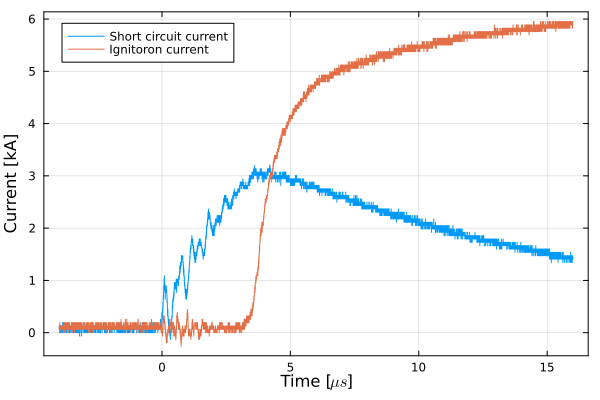

In [2]:
using Plots
using DataFrames
using CSV
using LsqFit
using LaTeXStrings
using QuadGK

df = CSV.read("data/D04AB.csv", DataFrame, header=21)

plot(df.TIME*1e6, df.CH1*800/1e3,label="Short circuit current", framestyle=:box)
plot!(df.TIME*1e6, df.CH2*800/1e3, label="Ignitoron current")
xlabel!(L"Time [$\mu s$]")
ylabel!("Current [kA]")
#savefig("plot1.pdf")

### 2. データの取り出し
- Crowbar work前後でデータを分ける

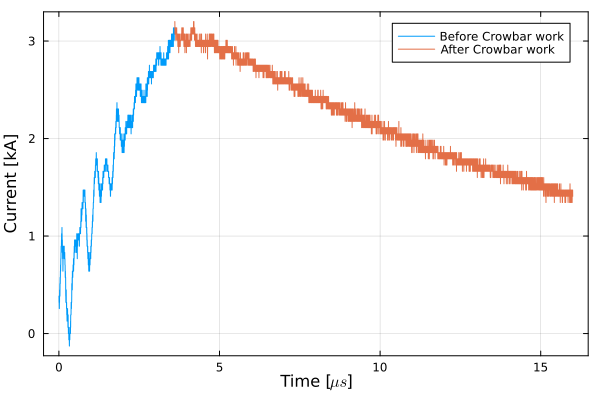

In [3]:
df1 = df[df.TIME.>0,:]
dft1 = df1[df1.CH1.>=maximum(df1.CH1), :]
t1 = dft1.TIME[1]
df2 = df1[df1.TIME.< t1, :]
plot(df2.TIME*1e6, df2.CH1*800/1e3, label="Before Crowbar work", framestyle=:box)
df3 = df1[df1.TIME.>= t1, :]
plot!(df3.TIME*1e6, df3.CH1*800/1e3, label="After Crowbar work")
xlabel!(L"Time [$\mu s$]")
ylabel!("Current [kA]")

### 3. フィッティングモデルの定義
$$
i_1(t) = A\left( e^{\lambda_1 t} - e^{\lambda_2 t} \right)\;,\; i_2(t) = I_0 e^{-(t - t_1)/\tau}
$$

Fitted Parameters1: [1669.2430548454674, 175156.6841260058, -863061.4924105743]
Fitted Parameters2: [3188.9039328477156, 1.5426790968447123e-5]


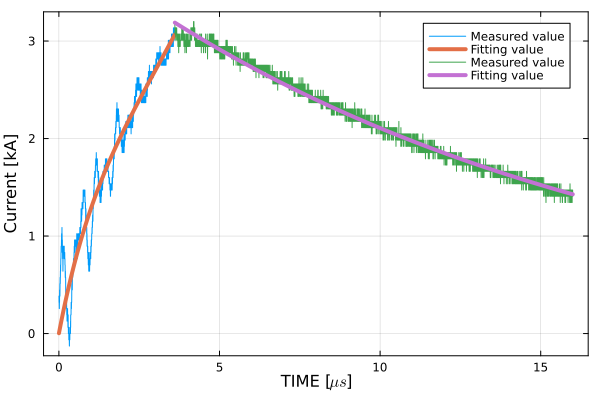

In [4]:
# モデルの定義
i1(t, p) = @. p[1] * (exp(p[2]*t) - exp(p[3]*t))
i2(t, q) = @. q[1] * exp(-((t - t1)/q[2]))
# 初期パラメータの推測
initial_params1 = [1, -1, .1]
initial_params2 = [4000,10e-6]
# フィッティングの実行
fit_result1 = curve_fit(i1, df2.TIME, df2.CH1*800, initial_params1)
fit_result2 = curve_fit(i2, df3.TIME, df3.CH1*800, initial_params2)
# フィッティングされたパラメータ
fitted_params1 = fit_result1.param
println("Fitted Parameters1: ", fitted_params1)
fitted_params2 = fit_result2.param
println("Fitted Parameters2: ", fitted_params2)
# フィッティング結果を使用してy値を計算
yfit1 = i1(df2.TIME, fitted_params1)
yfit2 = i2(df3.TIME, fitted_params2)

plot(df2.TIME*1e6, df2.CH1*800/1e3, label="Measured value", framestyle=:box)
plot!(df2.TIME*1e6 ,yfit1/1e3, label="Fitting value",linewidth=4)
plot!(df3.TIME*1e6, df3.CH1*800/1e3, label="Measured value")
plot!(df3.TIME*1e6 ,yfit2/1e3, label="Fitting value", linewidth=4)
xlabel!(L"TIME [$\mu s$]")
ylabel!("Current [kA]")
#savefig("plot2.pdf")

### 4. 銅細線の抵抗値

銅線の抵抗値 $ R $ は、

$$
R = \rho \frac{L}{A}
$$

ただし、

- $ R $: 抵抗値（Ω）
- $ \rho $: 銅の抵抗率（20°Cにおいて約 $1.72 \times 10^{-8} \, \Omega \cdot m $）
- $ L $: 銅線の長さ（m）
- $ A $: 銅線の断面積（$ m^2 $）

銅線は断面積は

$$
A = \pi \left( \frac{d}{2} \right)^2
$$

ここで、直径 $ d = 0.35 \, \text{mm} = 0.35 \times 10^{-3} \, \text{m} $ 、長さ $ L = 200 \, \text{mm} = 0.2 \, \text{m} $ として抵抗値を計算すると

In [5]:
# 定数
rho_copper = 1.72e-8  # 銅の抵抗率 (Ω·m)
d = 0.35e-3  # 銅線の直径 (m)
L = 0.2  # 銅線の長さ (m)

# 銅線の断面積 (m^2)
A = π * (d / 2) ^ 2

# 抵抗値 (Ω)
R = rho_copper * L / A

0.03575464517460375

### 4. 銅細線で消費されるエネルギー
$$
Q_1 = R A^2 \left[ \frac{e^{2\lambda_1 t_1} - 1}{2\lambda_1}  - \frac{2 \{ e^{(\lambda_1 + \lambda_2)t_1} - 1 \}}{\lambda_1 + \lambda_2}  + \frac{e^{2\lambda_2   t_1} - 1}{2\lambda_2} \right],\quad Q_2 = \frac{R I_0^2\tau}{2}
$$



In [6]:
A = fitted_params1[1]
λ1 = fitted_params1[2]
λ2 = fitted_params1[3]
Q1 = R*A^2*((exp(2*λ1*t1)-1)/(2*λ1) - 2*(exp((λ1+λ2)*t1)-1)/(λ1+λ2) + (exp(2*λ2*t1)-1)/(2*λ2))
println("Energy consumption: ", Q1, "[J]")

I0 = fitted_params2[1]
τ = fitted_params2[2]
Q2 = R*I0^2*τ/2
println("Energy consumption: ", Q2, "[J]")
println("Total consumption: ", Q1+Q2, "[J]")

Energy consumption: 0.514988207707439[J]
Energy consumption: 2.8045355148236233[J]
Total consumption: 3.3195237225310623[J]


A: 5597.180406917462 λ1: -4071.72034998842 λ2: -227088.70498519414 L: 72.10000000000001[μH]


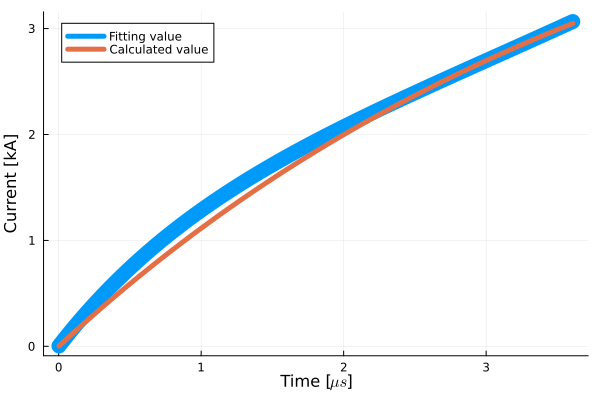

In [13]:
R1 = 70/6 + 5
#L1 = - R1 /(fitted_params1[2] + fitted_params1[3])
L1 = 72.1e-6
C = 15e-6
V0 = 90e3

λ11 = -(R1/(2L1))+sqrt((R1/2L1)^2 - 1/(L1*C))
λ22 = -(R1/(2L1))-sqrt((R1/2L1)^2 - 1/(L1*C))
β = (λ11 - λ22)/2
A1 = V0/(2*β*L1)

println("A: ", A1, " λ1: " , λ11, " λ2: ", λ22, " L: ", L1*1e6, "[μH]")

ycal1 = i1(df2.TIME, [A1, λ11, λ22])

plot(df2.TIME*1e6 ,yfit1/1e3, linewidth=15, label="Fitting value")
plot!(df2.TIME*1e6 ,ycal1/1e3, linewidth=5, label="Calculated value")
xlabel!(L"Time [$\mu s$]")
ylabel!("Current [kA]")

L: 77.13395484223561 [μH]


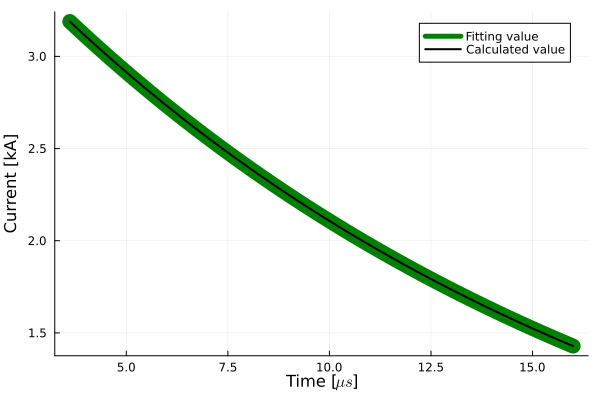

In [8]:
I0 = fitted_params2[1]
τ = fitted_params2[2]
L2 = 5 * τ

println("L: ", L2*1e6, " [μH]")

ycal2 = i2(df3.TIME, [I0, τ])

plot(df3.TIME*1e6 ,yfit2/1e3, linewidth=15, linecolor="green", label="Fitting value")
plot!(df3.TIME*1e6 ,ycal2/1e3, linewidth=2,linecolor="black",label="Calculated value")
xlabel!(L"Time [$\mu s$]")
ylabel!("Current [kA]")

In [ ]:

f(x) = R*(A * (exp(λ1 *x) - exp(λ2 *x)))^2
g(x) = R*(I0* exp(-((x - t1)/τ)))^2

Q1 = quadgk(f, 0, t1)
Q2 = quadgk(g, t1, 1)
Q1[1]+Q2[1]
println("Q1:\t", Q1[1], "\t[J]\n" , "Q2:\t", Q2[1], "\t[J] \n", "Q:\t", Q1[1]+Q2[1], "\t[J] ")


# Selection of Test Wire

$$
U = \rho l A \int^{T_f}_{T_0}C(T) dT = \rho l A C(T)(T_f - T_0)



In [ ]:
ρ = 8900
HC = 385
Tf = 1083
T0 = 25
d = 0.35e-3
l = 200e-3

A = π*(d/2)^2

U = ρ*l*A*HC*(Tf - T0)

In [ ]:
6.49^2*0.036*20